# Setup and Importing Weekly Price Data 

Our first step is to set up our environment and import Fanduel price data for the slate of games in question into a DataFrame.

In [32]:
#Importing weekly price data
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import linear_model

df = pd.read_csv('FanDuel-NFL-2020-11-22-51732-players-list.csv').dropna(how='all',axis='columns').drop('Nickname',axis=1)
df.head()

,Id,Position,First Name,Last Name,FPPG,Played,Salary,Game,Team,Opponent,Injury Indicator,Injury Details
0,51732-54140,RB,Dalvin,Cook,25.787500,8,10500,DAL@MIN,MIN,DAL,NaN,NaN
1,51732-55050,RB,Christian,McCaffrey,16.380000,5,10000,DET@CAR,CAR,DET,NaN,Shoulder - ac joint
2,51732-42104,RB,Alvin,Kamara,23.655555,9,9700,ATL@NO,NO,ATL,NaN,NaN
3,51732-45889,WR,Davante,Adams,22.371429,7,9500,GB@IND,GB,IND,NaN,NaN
4,51732-6894,QB,Aaron,Rodgers,23.835556,9,9000,GB@IND,GB,IND,NaN,NaN


# Data Cleaning

We need our data to be rid of unnecessary values. Let's remove:
- Players designated as out
- Players averaging 0 FPPG
    - These are our edge cases that additional research will need to be done on (e.g. AJ Green)
- Minimum salary players (for now)
    - QB 6000
    - RB 4500
    - WR 4500
    - TE 4000


In [33]:
#Data Cleaning
df = df[(df['Injury Indicator'] != 'O') & (df['Injury Indicator'] != 'IR')]
df = df[df.FPPG > 0]
df = df[((df.Position == 'QB') & (df.Salary > 6000)) | ((df.Position == 'RB') & (df.Salary > 4500)) | ((df.Position == 'WR') & (df.Salary > 4500)) | ((df.Position == 'TE') & (df.Salary > 4000)) | (df.Position == 'D')]

# First Visualizations

Let's start by visualizing all players in a scatter plot: FPPG vs Salary.

Preliminary Observations:
 - There are a lot of TEs at the 4500 mark, presumably backups who get enough playing time to warrant a greater than minimum salary.
 - Above 5000 we seem to have a pretty linear relationship between fantasy production and salary. Let's look at this relationship by position.
 - D/ST salaries don't seem to be correlated to prior fantasy production. This is likely because D/ST scoring is highly correlated to strength of opponent offense.

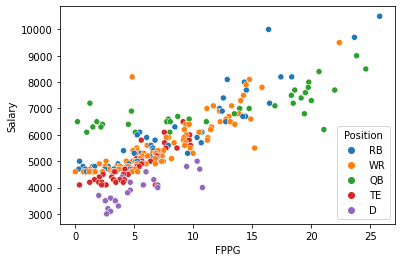

In [34]:
sns.scatterplot(data=df,x='FPPG',y='Salary',hue='Position')
plt.show()

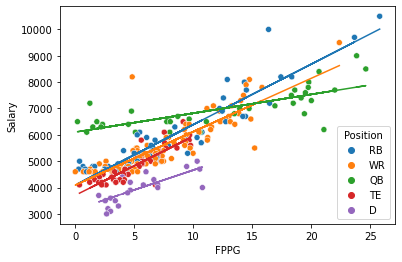

In [35]:
#Mapping positions to colors to visualize pricing
QB = df[(df['Position'] == 'QB')]
RB = df[(df['Position'] == 'RB')]
WR =  df[(df['Position'] == 'WR')]
TE = df[(df['Position'] == 'TE')]
D = df[(df['Position'] == 'D')]

lr = linear_model.LinearRegression()
Y3 = QB['Salary'].values.reshape(-1,1)
X3 = QB['FPPG'].values.reshape(-1,1)
lr.fit(X3, Y3)
Y_pred3 = lr.predict(X3)

Y1 = RB['Salary'].values.reshape(-1,1)
X1 = RB['FPPG'].values.reshape(-1,1)
lr.fit(X1, Y1)
Y_pred1 = lr.predict(X1)

Y2 = WR['Salary'].values.reshape(-1,1)
X2 = WR['FPPG'].values.reshape(-1,1)
lr.fit(X2, Y2)
Y_pred2 = lr.predict(X2)

Y4 = TE['Salary'].values.reshape(-1,1)
X4 = TE['FPPG'].values.reshape(-1,1)
lr.fit(X4, Y4)
Y_pred4 = lr.predict(X4)

Y5 = D['Salary'].values.reshape(-1,1)
X5 = D['FPPG'].values.reshape(-1,1)
lr.fit(X5, Y5)
Y_pred5 = lr.predict(X5)


sns.scatterplot(data=df,x='FPPG',y='Salary',hue='Position')


plt.plot(X1,Y_pred1)
plt.plot(X2,Y_pred2)
plt.plot(X3,Y_pred3)
plt.plot(X4,Y_pred4)
plt.plot(X5,Y_pred5)


plt.show()

# Generating Lineups
Our next step is to generate some optimal or near-optimal lineups based on available data. We could probably iterate through all possible combinations, but for now let's use some popular metaheuristics. DFS lineups are a modified version of the knapsack problem, a classic problem in combinatorial optimization. DFS lineups add the constraints of positional limitations.

In [51]:
class Player:
    def __init__(self,pos,fname,lname,fppg,played,salary,game,team,opponent,injuryInd,injuryDetails):
        self.pos = pos
        self.name = fname+" "+lname
        self.fppg = float(fppg)
        self.played = int(played)
        self.salary = int(salary)
        self.game = game
        self.team = team
        self.opponent = opponent
        self.injuryInd = injuryInd
        self.injuryDetails = injuryDetails
        self.rawvalue = float(self.salary)/self.fppg

    def __str__(self):
        return self.name + " has a raw value of " + "{:.2f}".format(self.rawvalue)+ " and a cost of " + str(self.salary)

    def isHome(self):
        teams = self.game.split("@")
        if teams[1] == self.team:
            return True
        return False


In [53]:
#Create example player
row = df.loc[0,:]
attrs = [row[col] for col in df.columns[1:]]
p1 = Player(*attrs)
print(p1)
p1.isHome()

Dalvin Cook has a raw value of 407.17 and a cost of 10500


True

In [ ]:
class Lineup:
    def __init__(self,qb,rb1,rb2,wr1,wr2,te,dst,flex):
        self.team = [qb,rb1,rb2,wr1,wr2,te,dst,flex]
        self.lineupValue = self.totalValue()
        #self.lineupDf = pd.DataFrame({'Lineup':self.lineups,'Value':self.lineupValue})
        
    def totalValue(self, maxWeight=60000):
        if len(players.Id) != len(set(players.Id)):
            return 0
        qb = len(players[players.Position == "QB"])
        rb = len(players[players.Position == "RB"])
        wr = len(players[players.Position == "WR"])
        te = len(players[players.Position == "TE"])
        dst = len(players[players.Position == "D"])
        if qb == 1 and dst == 1 and rb >= 2 and wr >=3 and te >= 1:
            return sum(players['FPPG'])if sum(players['Salary']) < maxWeight else 0
        return 0

In [55]:


class Population:
    def __init__(self,lineups):
        self.lineups = lineups
        self.lineupValue = [self.totalValue(lineup) for lineup in self.lineups]
        self.lineupDf = pd.DataFrame({'Lineup':self.lineups,'Value':self.lineupValue})
        
    def totalValue(self,players, maxWeight=60000):
        if len(players.Id) != len(set(players.Id)):
            return 0
        qb = len(players[players.Position == "QB"])
        rb = len(players[players.Position == "RB"])
        wr = len(players[players.Position == "WR"])
        te = len(players[players.Position == "TE"])
        dst = len(players[players.Position == "D"])
        if qb == 1 and dst == 1 and rb >= 2 and wr >=3 and te >= 1:
            return sum(players['FPPG'])if sum(players['Salary']) < maxWeight else 0
        return 0

In [56]:
#Let's be smart about initial sampling: start with 1 QB, 1 TE, 1 DST
qbs = df[df.Position == "QB"]
tes = df[df.Position == "TE"]
ds = df[df.Position == "D"]
rbs = df[df.Position == "RB"]
wrs = df[df.Position == "WR"]
flex = pd.concat([rbs,wrs,tes])
lineups = []
for i in range(30):
    lineup = pd.concat([qbs.sample(),rbs.sample(n=2),wrs.sample(n=2),tes.sample(),ds.sample(),flex.sample()])
    lineups.append(lineup)
initialPopulation = Population(lineups)

In [ ]:
def selection(pop_after_fit,n_parents):
    return pop_after_fit.head(n_parents)

def crossover(pop_after_sel):
    population_nextgen=pop_after_sel
    for i in range(len(pop_after_sel)):
        for j in range(0,len(pop_after_cross)):
            if i!=j:
                parent1 = pop_after_sel[i]
                parent2 = pop_after_sel[j]
                
        population_nextgen.append(child)
    return population_nextgen

def mutation(pop_after_cross,mutation_rate):
    population_nextgen = []
    for i in range(0,len(pop_after_cross)):

        chromosome = pop_after_cross[i]
        for j in range(len(chromosome)):
            if random.random() < mutation_rate:
                chromosome[j]= not chromosome[j]
        population_nextgen.append(chromosome)
    return population_nextgen

def generations(initPop, n_parents,mutation_rate,n_gen):
    pop_after_fit = initPop
    pop_after_fit.sort_values(by='Value',inplace=True)
    best = pop_after_fit.head(1)
    for i in range(n_gen):
        pop_after_sel = selection(pop_after_fit,n_parents)
        pop_after_cross = crossover(pop_after_sel)
        population_nextgen = mutation(pop_after_cross,mutation_rate)
        population_nextgen.sort_values(by='Value',inplace=True)
        best.append(population_nextgen.head(1))
    return best

bestLineups = generations(initPop = initialPopulation,n_parents=10,mutation_rate=.05,n_gen=100)

# Scoring System Overview

<img src='Fanduel Scoring.png'>

 - Half PPR
 - Decimal Scoring (devalues TDs slightly)
 - INTs are only -1
 - Return TDs count for player and DST